In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D


In [2]:
File_1 = 'anonymized_radio_space_WM1_4.csv'
File_2 = 'anonymized_radio_space_WM1_5.csv'

df1 = pd.read_csv(File_1)
df2 = pd.read_csv(File_2)

dataset = pd.merge(df1, df2, how='outer')
dataset.to_csv('merged_dataset.csv')



In [3]:
#1.	Per ogni dispositivo estrarre le seguenti features: chan, datr, lsnr, rssic, FCnt.

features = ['dev_addr', 'chan', 'datr', 'lsnr', 'rssic', 'FCnt']

device_data = dataset[features]
device_data.head()

,dev_addr,chan,datr,lsnr,rssic,FCnt
0,000000f9,23,SF7BW125,3.0,-103,1576914716
1,000000f9,23,SF7BW125,3.0,-103,1576914718
2,000000f9,7,SF7BW125,12.0,-91,1576914718
3,000000f9,5,SF7BW125,11.0,-93,1576952897
4,000000f9,21,SF7BW125,-1.0,-106,1576952897


In [4]:
#2. Evidenziare il numero di device e il numero di pacchetti per device
num_device = device_data['dev_addr'].nunique()  # Numero di dispositivi unici
num_package_for_dev = device_data.groupby('dev_addr').size()  # Numero di pacchetti per dispositivo

# Visualizza i risultati
print("Numero di dispositivi unici:", num_device)
print("\nNumero di pacchetti per dispositivo:")
print(num_package_for_dev)

Numero di dispositivi unici: 110

Numero di pacchetti per dispositivo:
dev_addr
00000000    3743
00000001    2886
00000002    4214
00000003    3213
00000004    2085
            ... 
0000009d       3
000000f8    1230
000000f9    3158
000000fa    2374
000000fb    1262
Length: 110, dtype: int64


In [5]:
def convert_substring_to_decimal(input_string, start_delimiter, end_delimiter):
    try:
        if input_string is not None:
            start_index = input_string.find(start_delimiter)
            end_index = input_string.find(end_delimiter, start_index + len(start_delimiter)) if start_index != -1 else -1
            substring = input_string[start_index + len(start_delimiter):end_index] if start_index != -1 and end_index != -1 else input_string
            decimal_value = int(substring)
            return decimal_value
        else:
            return None
    except ValueError:
        print(f"Errore: Impossibile convertire la sottostringa '{substring}' in decimale.")
        return None
    except Exception as e:
        print(f"Errore generico: {e}")
        return None

# Applicare la funzione convert_substring_to_decimal alla colonna 'datr'
dataset['datr'] = dataset['datr'].apply(lambda x: convert_substring_to_decimal(x, 'SF', 'BW'))
dataset['datr'].head()

0    7
1    7
2    7
3    7
4    7
Name: datr, dtype: int64

In [6]:
#3.	Applicare un metodo di StandardScalar ai dati prima delle tecniche di clustering.

# Lista delle colonne numeriche
numeric_columns = ['chan', 'datr', 'lsnr', 'rssic', 'FCnt']

# Seleziona solo le colonne numeriche dal dataset
numeric_data = dataset[numeric_columns]

# Applica la Z-score normalization solo alle colonne numeriche
means = numeric_data.mean()
stds = numeric_data.std()

normalized_dataset = (numeric_data - means) / stds

# Concatena le colonne non numeriche al dataset normalizzato
normalized_dataset = pd.concat([dataset[['dev_addr']], normalized_dataset], axis=1)
print(normalized_dataset)


        dev_addr      chan      datr      lsnr     rssic      FCnt
0       000000f9  1.018459 -0.539458  0.481374 -0.049984 -0.156547
1       000000f9  1.018459 -0.539458  0.481374 -0.049984 -0.156547
2       000000f9 -0.983402 -0.539458  1.461653  1.660602 -0.156547
3       000000f9 -1.233634 -0.539458  1.352733  1.375504 -0.154344
4       000000f9  0.768226 -0.539458  0.045695 -0.477630 -0.154344
...          ...       ...       ...       ...       ...       ...
352777  0000009a -1.108518 -0.539458 -0.389985 -0.620179  0.467707
352778  0000009a -0.983402 -0.539458 -0.281065 -0.620179  0.453969
352779  0000009a -0.983402 -0.539458 -0.498904 -0.620179  0.467707
352780  0000009a  1.018459 -0.539458  0.394238  0.092565  0.467708
352781  0000009a  1.018459 -0.539458  0.459590 -0.192533  0.470200

[352782 rows x 6 columns]


In [7]:
#4.	Si selezionino 5 dispositivi in modo random e si verifichi l’esistenza di una correlazione tra le features selezionate.

# Seleziona casualmente 5 dispositivi
random_devices = np.random.choice(dataset['dev_addr'].unique(), size=5)
selected_devices_data = dataset[dataset['dev_addr'].isin(random_devices)]

# Seleziona le colonne desiderate per la correlazione
selected_data = selected_devices_data[['chan', 'datr', 'lsnr', 'rssic', 'FCnt']]

# Calcola la correlazione tra le features
correlation_matrix = selected_data.corr()

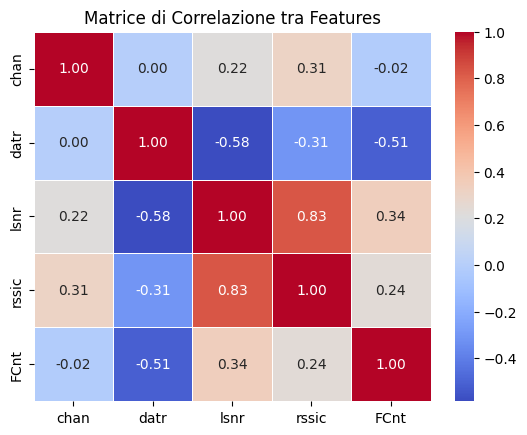

In [8]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice di Correlazione tra Features')
plt.show()

In [9]:
# 5. Raggruppare il dataset per dispositivo.
grouped_by_device = normalized_dataset.groupby('dev_addr')

# Visualizza alcune informazioni sui gruppi
for device, group_data in grouped_by_device:
    print(f"Dispositivo: {device}")
    print(group_data.head())  # Stampa le prime righe di ciascun gruppo
    print("\n")



Dispositivo: 00000000
        dev_addr      chan      datr      lsnr     rssic      FCnt
179029  00000000 -0.983402 -0.539458 -0.825664 -0.620179  0.434430
179030  00000000  1.018459 -0.539458  0.699214  0.235114  0.434430
179031  00000000  0.893342 -0.539458  0.699214  0.235114  0.436924
179032  00000000 -1.108518 -0.539458 -0.716744 -0.620179  0.436924
179033  00000000  1.018459 -0.539458  0.590294 -0.049984  0.446891


Dispositivo: 00000001
        dev_addr      chan      datr      lsnr     rssic     FCnt
180068  00000001 -1.233634 -0.539458 -0.694960 -1.190375 -1.22332
180069  00000001 -1.233634 -0.539458 -0.694960 -1.190375 -1.22332
180070  00000001 -1.233634 -0.539458 -0.825664 -0.762728 -1.22332
180071  00000001 -1.233634 -0.539458 -0.825664 -0.762728 -1.22332
180072  00000001 -0.983402 -0.539458 -0.825664 -0.762728 -1.22332


Dispositivo: 00000002
        dev_addr      chan      datr      lsnr     rssic      FCnt
170919  00000002  0.768226 -0.539458  1.134893  0.947858  1.78300

In [10]:
# 6. Associare a ogni dispositivo 5 nuove caratteristiche ottenute tramite media delle prime 4 features e la differenza MAX-MIN per 'FCnt'.
new_features_list = []

for device, group_data in grouped_by_device:
    mean_features = group_data[['chan', 'datr', 'lsnr', 'rssic']].mean()
    fcnt_difference = group_data['FCnt'].max() - group_data['FCnt'].min()

    new_features_dict = {
        'dev_addr': device,
        'Mean_Chan': mean_features['chan'],
        'Mean_Datr': mean_features['datr'],
        'Mean_Lsnr': mean_features['lsnr'],
        'Mean_Rssic': mean_features['rssic'],
        'FCnt_Difference': fcnt_difference
    }

    new_features_list.append(new_features_dict)

new_dataset = pd.DataFrame(new_features_list)
print(new_dataset.head)


<bound method NDFrame.head of      dev_addr  Mean_Chan  Mean_Datr  Mean_Lsnr  Mean_Rssic  FCnt_Difference
0    00000000   0.001350  -0.212683  -0.165333   -0.274185         3.038000
1    00000001  -0.009870  -0.466972   0.379519    0.177818         3.033023
2    00000002  -0.099482  -0.439238   1.107754    1.117029         3.035517
3    00000003  -0.250772   0.475508  -0.298065   -0.416671         3.038041
4    00000004   0.304066   0.374332  -0.666563   -0.540598         3.038007
..        ...        ...        ...        ...         ...              ...
105  0000009d  -0.566347   2.272308  -0.716744   -0.382598         0.000000
106  000000f8  -0.119286  -0.539458   1.024317    0.866501         0.578192
107  000000f9  -0.122881  -0.447216   0.647551    0.537184         3.038012
108  000000fa  -0.487100  -0.464130  -0.018281   -0.233544         3.038005
109  000000fb  -0.107489   2.021433  -0.871536   -0.454362         0.690339

[110 rows x 6 columns]>


c:\Users\gioac\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gioac\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gioac\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gioac\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

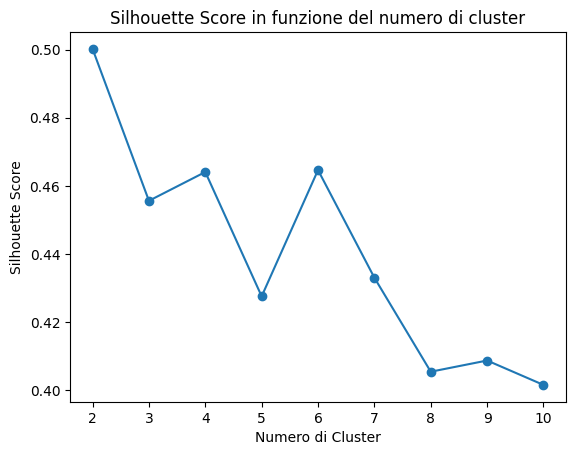

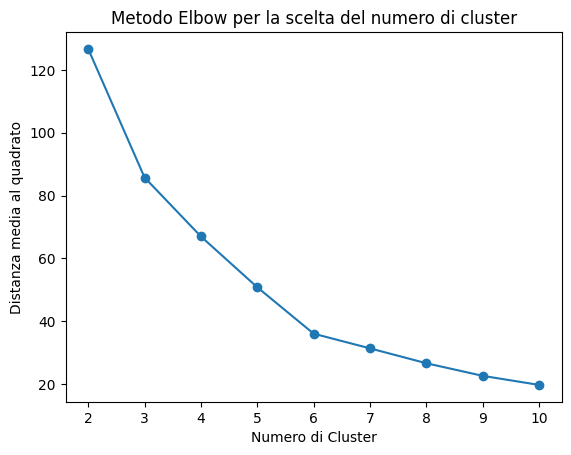

In [11]:
#7.	Utilizzare le fetures selezionate per applicare la clusterizzazione di tipo k-means.
#Utilizzare il metodo Elbow e Silhouette Score, per scegliere il numero corretto di cluster.

# Seleziona le features per il clustering
selected_features = ['Mean_Chan', 'Mean_Datr', 'Mean_Lsnr', 'Mean_Rssic', 'FCnt_Difference']
data_for_clustering = new_dataset[selected_features]

# Inizializza una lista per salvare i risultati del Silhouette Score e del metodo Elbow
scores_silhouette, scores_elbow = [], []

# Prova un numero di cluster da 2 a 10
for num_clusters in range(2, 11):
    # Inizializza il modello di k-means
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    
    # Addestra il modello e predici i cluster
    labels = kmeans.fit_predict(data_for_clustering)
    
    # Calcola il Silhouette Score e aggiungilo alla lista
    silhouette_avg = silhouette_score(data_for_clustering, labels)
    scores_silhouette.append(silhouette_avg)

    # Aggiungi l'inertia al metodo Elbow
    scores_elbow.append(kmeans.inertia_)

# Visualizza il grafico del Silhouette Score
plt.plot(range(2, 11), scores_silhouette, marker='o')
plt.title('Silhouette Score in funzione del numero di cluster')
plt.xlabel('Numero di Cluster')
plt.ylabel('Silhouette Score')
plt.show()

# Visualizza il grafico del metodo Elbow
plt.plot(range(2, 11), scores_elbow, marker='o')
plt.title('Metodo Elbow per la scelta del numero di cluster')
plt.xlabel('Numero di Cluster')
plt.ylabel('Distanza media al quadrato')
plt.show()



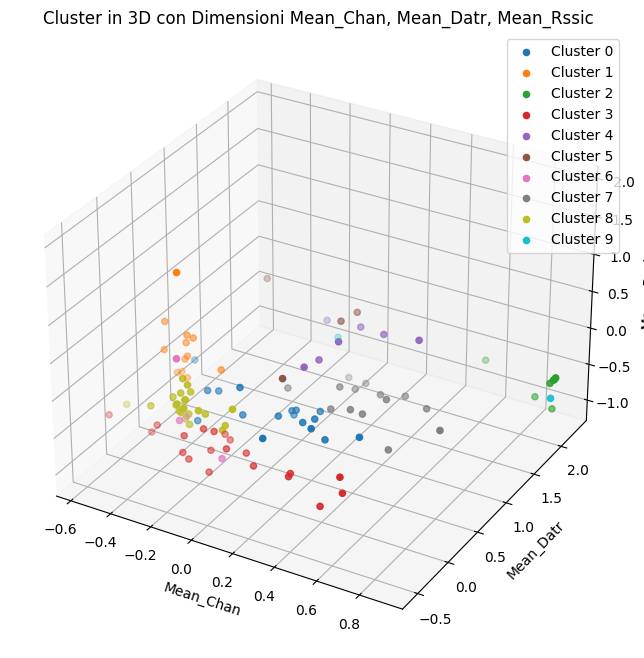

In [12]:
#8.	Mostrare i cluster in un grafico 3D le cui dimensioni sono chan, datr, lsnr. 

# Visualizza il grafico 3D dei cluster
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Assegna colori diversi ai cluster
for i in range(num_clusters):
    cluster_data = new_dataset[labels == i]
    ax.scatter(cluster_data['Mean_Chan'], cluster_data['Mean_Datr'], cluster_data['Mean_Rssic'], label=f'Cluster {i}')

# Etichette degli assi
ax.set_xlabel('Mean_Chan')
ax.set_ylabel('Mean_Datr')
ax.set_zlabel('Mean_Rssic')

# Legenda
ax.legend()

# Titolo del grafico
plt.title('Cluster in 3D con Dimensioni Mean_Chan, Mean_Datr, Mean_Rssic')

# Mostra il grafico
plt.show()